# DML for ATE and LATE of 401(k) on Wealth

## Inference on Predictive and Causal Effects in High-Dimensional Nonlinear Models

## Impact of 401(k) on  Financial Wealth

As a practical illustration of the methods developed in this lecture, we consider estimation of the effect of 401(k) eligibility and participation 
on accumulated assets. 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job. 

## Data

The data set can be loaded from the `hdm` package for R by typing



In [3]:
#pip install -U DoubleML

In [19]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import hdmpy
import pyreadr
import warnings
warnings.filterwarnings('ignore')

In [20]:
rdata_read = pyreadr.read_r("../data/pension.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'pension' ]

data.shape

(9915, 44)

See the "Details" section on the description of the data set, which can be accessed by 


In [21]:
pension = data.copy()

The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

In [22]:
sns.set()
colors = sns.color_palette()

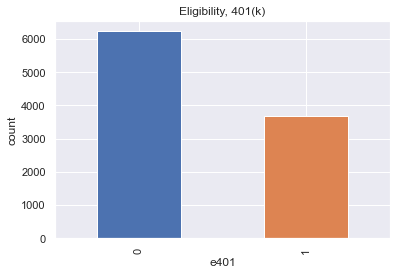

In [23]:
data['e401'].value_counts().plot(kind='bar', color=colors)
plt.title('Eligibility, 401(k)')
plt.xlabel('e401')
_ = plt.ylabel('count')

Eligibility is highly associated with financial wealth:

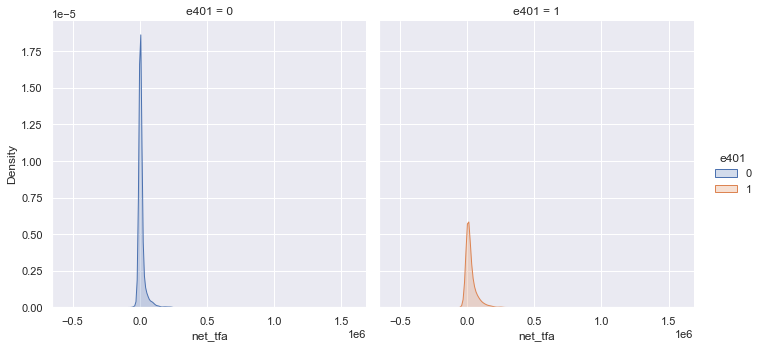

In [24]:
_ = sns.displot(data, x="net_tfa", hue="e401", col="e401",
                kind="kde", fill=True)

The unconditional APE of e401 is about $19559$:

In [25]:
data[['e401', 'net_tfa']].groupby('e401').mean().diff()

,net_tfa
e401,
0,NaN
1,19559.34475


Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [26]:
data[['p401', 'net_tfa']].groupby('p401').mean().diff()

,net_tfa
p401,
0,NaN
1,27371.583404


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

## Double ML package

We are interested in valid estimators of the average treatment effect of `e401` and `p401` on `net_tfa`. To get those estimators, we use the `DoubleML` package that internally builds on mlr3. You find additional information on the package on the package website https://docs.doubleml.org/ and the R documentation page https://docs.doubleml.org/r/stable/. 

As mentioned, in the tutorial we use the meta package `mlr3` to generate predictions with machine learning methods. A comprehensive introduction and description of the `mlr3` package is provided in the [mlr3book](https://mlr3book.mlr-org.com/). A list of all learners that you can use in `mlr3` can be found [here](https://mlr3extralearners.mlr-org.com/articles/learners/list_learners.html). The entry in the columns *mlr3 Package* and *Packages* indicate which packages must be installed/loaded in your R session. 

## Estimating the ATE of 401(k) Eligibility on Net Financial Assets

We first look at the treatment effect of e401 on net total financial assets. We give estimates of the ATE and ATT that corresponds to the linear model

\begin{align}
Y = D \alpha + f(X)'\beta+ \epsilon
\end{align}

where $f(X)$ includes indicators of marital status, two-earner status, defined benefit pension status, IRA participation status, and home ownership status, and  orthogonal polynomials of degrees 2, 4, 6 and 8 in family size, education, age and  income, respectively. The dimensions of $f(X)$ is 25. 

In the first step, we report estimates of the average treatment effect (ATE) of 401(k) eligibility on net financial assets both in the partially linear regression (PLR) model and in the interactive regression model (IRM) allowing for heterogeneous treatment effects. 


We can not use np.log in `inc` variable since it has negative values. As a result, we got a column with some `None` values. Those observations have problems with `poly.fit_transform` function since it does not admit `NaN` values **(uncomment and run the code below for a example)**. I decided to low down the degree of the polynomial to **6** for some estimations: random forest, decision trees, etc. So, we are going to use create datasets: **data_ml** (8 degree `inc`) and **data_ml_aux** (6 degree `inc`).

### Main Data

In [27]:
# Constructing the data (as DoubleMLData)
features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]

poly_dict = {'age': 6,
             'inc': 8,
             'educ': 4,
             'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(data[[key]])
    x_cols = poly.get_feature_names([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)
    
    features = pd.concat((features, data_transf),
                          axis=1, sort=False)

model_flex = pd.concat((data.copy()[['net_tfa', 'e401']], features.copy()),
                        axis=1, sort=False)

x_cols = model_flex.columns.to_list()[2:]

# Initialize DoubleMLData (data-backend of DoubleML)
data_ml = dml.DoubleMLData(model_flex, y_col='net_tfa', \
                           d_cols ='e401' , x_cols = x_cols)

p = model_flex.shape[1] - 2
print(p)

25


### Auxiliary data
We are going to use this data since sklearn has some problems with values greater than `float32`.

In [28]:
# Constructing the data (as DoubleMLData)
features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]

poly_dict = {'age': 6,
             'inc': 6,
             'educ': 4,
             'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(data[[key]])
    x_cols = poly.get_feature_names([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)
    
    features = pd.concat((features, data_transf),
                          axis=1, sort=False)

model_flex = pd.concat((data.copy()[['net_tfa', 'e401']], features.copy()),
                        axis=1, sort=False)

x_cols = model_flex.columns.to_list()[2:]

# Initialize DoubleMLData (data-backend of DoubleML)
data_ml_aux = dml.DoubleMLData(model_flex, y_col='net_tfa', \
                           d_cols ='e401' , x_cols = x_cols)

In [29]:
# data_interactions
#fetch_401K( return_type  = 'DataFrame' , polynomial_features = True )

## Partially Linear Regression Models (PLR)

We start using lasso to estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{align}\tag{1}
Y = D\theta_0 + g_0(X) + \zeta,  &  E[\zeta \mid D,X]= 0,\\
\end{align}
\begin{align}\tag{2}
D = m_0(X) +  V,   &  E[V \mid X] = 0.
\end{align}

In [30]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000))
lasso_class = make_pipeline(StandardScaler(),
                            LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear',
                                                 Cs = Cs, max_iter=1000))

np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr = dml.DoubleMLPLR(data_ml_aux,
                                ml_g = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)

dml_plr.fit(store_predictions=True)

lasso_plr = dml_plr.summary.coef[0]
lasso_std_plr = dml_plr.summary['std err'][0]
dml_plr.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8919.577401,1325.857662,6.727402,1.727192e-11,6320.944135,11518.210667


Let us check the predictive performance of this model.

In [44]:
dml_plr.params_names

['ml_l', 'ml_m']

In [31]:
print(dml_plr.params_names)
g_hat = dml_plr.predictions[dml_plr.params_names[0]].flatten() # predictions of g_o
m_hat = dml_plr.predictions[dml_plr.params_names[1]].flatten() # predictions of m_o

['ml_l', 'ml_m']


In [32]:
y = pension.net_tfa.to_numpy()
theta = dml_plr.coef[ 0 ]
d = pension.e401.to_numpy()
predictions_y = d*theta + g_hat
lasso_y_rmse = np.sqrt( np.mean( ( y - predictions_y ) ** 2 ) ) 
lasso_y_rmse

54342.02430847791

In [33]:
# cross-fitted RMSE: treatment
d = pension.e401.to_numpy()
lasso_d_rmse = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( lasso_d_rmse )
# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

0.4585164421000309


0.31376701966717097

Then, we repeat this procedure for various machine learning methods.

### Sklearn VS Ranger

| Sklearn **(by default)**          | Ranger **(by default) [info](https://www.jstatsoft.org/article/view/v077i01)** 	|
|--------------------------------	|-----------------------	|
| max_features = “auto” =n_features | mtry = Null = 0         	|
| max_depth = None       	        | max.depth = Null = 0     	|
| min_samples_leaf = 1	            | min.node.size = Null = 0 	|
| n_estimators = 100                | num.trees = 500     	    |

We assured that `data_ml` in **Python** is exactly like the data generated by **R**. \
Even though we tried to adjust parameters of Sklearn models to meet default values of ranger, we could not overcome the NA  and Inf problems in predictions. We decided to use another package, `skranger`, which is a simil of `ranger` in **Python**. However, we got some problems installing the package in Windows10.

After reviewing the packages and reading [this repository](https://github.com/bikashkarmokar/float32_bug_sklearn), we conclude that Sklearn has problems with values greater than `float32`, and `sklearn` consider these values as `Inf`. Based on that information, we decided to use tha auxiliary data (**data_ml_aux**) for `RandomForestRegressor` and `DecisionTreeRegressor`.

We are going to use only income up to 6th grade since, `sklearn` has problems with numbers greater than float32. We decided to reduce numbers' size.

The `data_ml` in **Python** is equal to the generated by **R**.

We can compare the accuracy of this model to the model that has been estimated with lasso.

In [34]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators = 500  )

randomForest_class = RandomForestClassifier(
    n_estimators = 500 )


dml_plr = dml.DoubleMLPLR(data_ml_aux, ml_g = randomForest, \
                         ml_m = randomForest_class, n_folds = 3)

dml_plr.fit(store_predictions=True)

dml_plr.summary

forest_plr = dml_plr.coef
forest_std_plr = dml_plr.summary[ 'std err' ]

# Evaluation predictions
g_hat = dml_plr.predictions[dml_plr.params_names[0]].flatten() # predictions of g_o
m_hat = dml_plr.predictions[dml_plr.params_names[1]].flatten() # predictions of m_o

y = pension.net_tfa.to_numpy()
theta = dml_plr.coef[ 0 ]
predictions_y = d*theta + g_hat
forest_y_rmse = np.sqrt( np.mean( ( y - predictions_y ) ** 2 ) ) 
print( forest_y_rmse )

# cross-fitted RMSE: treatment
forest_d_rmse = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( forest_d_rmse )
# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

58456.527347918534
0.4659644938522823


0.3495713565305093

### Sklearn VS Rpart

| Sklearn (default)                                  	| Rpart.control (defualt)           	|
|----------------------------------------------------	|-----------------------------------	|
| min_samples_split = 2                              	| minsplit = 20                     	|
| max_depth = None (pure tree\| < min_samples_split) 	| maxdepth = 30                     	|
| min_samples_leaf = 1                               	| minbucket = round( `minsplit`/3 ) 	|
| ccp_alpha = 0.0                                    	| cp = 0.01 (doubts)                	|

In [45]:
# Trees
trees = DecisionTreeRegressor(
        max_depth=30, ccp_alpha=0.01, min_samples_split=20, \
        min_samples_leaf= np.round(20/3).astype(int))

trees_class = DecisionTreeClassifier( max_depth=30, ccp_alpha=0.01, \
                min_samples_split=20, \
                min_samples_leaf= np.round(20/3).astype(int) )

np.random.seed(123)
dml_plr = dml.DoubleMLPLR(data_ml_aux,
                               ml_g = trees,
                               ml_m = trees_class,
                               n_folds = 3)
dml_plr.fit(store_predictions=True)
tree_summary = dml_plr.summary
print(tree_summary)

dml_plr.fit(store_predictions=True)
dml_plr.summary

tree_plr = dml_plr.coef
tree_std_plr = dml_plr.summary[ 'std err' ]

# Evaluation predictions
g_hat = dml_plr.predictions[dml_plr.params_names[0]].flatten() # predictions of g_o
m_hat = dml_plr.predictions[dml_plr.params_names[1]].flatten() # predictions of m_o

y = pension.net_tfa.to_numpy()
theta = dml_plr.coef[ 0 ]
predictions_y = d*theta + g_hat
tree_y_rmse = np.sqrt( np.mean( ( y - predictions_y ) ** 2 ) ) 
print( tree_y_rmse )

# cross-fitted RMSE: treatment
tree_d_rmse = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( tree_d_rmse )
# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

             coef      std err         t         P>|t|        2.5 %  \
e401  8594.661891  1383.808638  6.210875  5.269052e-10  5882.446799   

            97.5 %  
e401  11306.876983  
58017.721042321384
0.4546690531536573


0.35269793242561776

In [47]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror" )
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", \
                            eval_metric = "logloss" )

np.random.seed(123)
dml_plr = dml.DoubleMLPLR( data_ml_aux ,
                                ml_g = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr.fit(store_predictions=True)
boost_summary = dml_plr.summary
print( boost_summary )

boost_plr = dml_plr.coef
boost_std_plr = dml_plr.summary[ 'std err' ]

# Evaluation predictions
g_hat = dml_plr.predictions[dml_plr.params_names[0]].flatten() # predictions of g_o
m_hat = dml_plr.predictions[dml_plr.params_names[1]].flatten() # predictions of m_o
y = pension.net_tfa.to_numpy()
theta = dml_plr.coef[ 0 ]
predictions_y = d*theta + g_hat

boost_y_rmse = np.sqrt( np.mean( ( y - predictions_y ) ** 2 ) ) 
print( boost_y_rmse )

# cross-fitted RMSE: treatment
boost_d_rmse = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( boost_d_rmse )

# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

             coef      std err         t         P>|t|        2.5 %  \
e401  9129.263678  1471.781415  6.202867  5.544386e-10  6244.625111   

            97.5 %  
e401  12013.902244  
62126.68237198471
0.4629817464588606


0.33605648008068584

Let's sum up the results:

In [48]:
table = np.zeros( (4, 4) )
table[0,0:4] = lasso_plr,forest_plr[0],tree_plr[0],boost_plr[0]
table[1,0:4] = lasso_std_plr,forest_std_plr,tree_std_plr,boost_std_plr
table[2,0:4] = lasso_y_rmse,forest_y_rmse,tree_y_rmse,boost_y_rmse
table[3,0:4] = lasso_d_rmse,forest_d_rmse,tree_d_rmse,boost_d_rmse
table_pd = pd.DataFrame( table , index = ["Estimate","Std.Error","RMSE Y","RMSE D" ], \
            columns = [ "Lasso","Random Forest","Trees","Boosting"])
table_pd

,Lasso,Random Forest,Trees,Boosting
Estimate,8919.577401,8702.588054,8601.584926,9129.263678
Std.Error,1325.857662,1310.423641,1383.825475,1471.781415
RMSE Y,54342.024308,58456.527348,58017.721042,62126.682372
RMSE D,0.458516,0.465964,0.454669,0.462982


The best model with lowest RMSE in both equation is the PLR model estimated via lasso. It gives the following estimate:

## Interactive Regression Model (IRM)

Next, we consider estimation of average treatment effects when treatment effects are fully heterogeneous:

 \begin{align}\tag{3}
 & Y  = g_0(D, X) + U,  &  \quad E[U \mid X, D]= 0,\\
\end{align} 
 \begin{align}\tag{4}
  & D  = m_0(X) + V,  & \quad  E[V\mid X] = 0.
\end{align}

To reduce the disproportionate impact of extreme propensity score weights in the interactive model
we trim the propensity scores which are close to the bounds.

We have problems with the **Lasso code**. When we run the code with the main data (**data_ml**) we got a very high coefficient (30964, **uncomment and run the code below to see results**). However, when I run the code with the auxiliary data (**data_aux**), I get results similar to the R output.  I assume that `inc^7` and `inc^8` variables are making troubles in Sklearn models.

In [49]:
# Lasso
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)
dml_irm = dml.DoubleMLIRM(data_ml_aux,
                          ml_g = lasso,
                          ml_m = lasso_class,
                          trimming_threshold = 0.01,
                          n_folds = 3)
dml_irm.fit(store_predictions=True) 
lasso_summary = dml_irm.summary
print(dml_irm.summary)

lasso_irm = dml_irm.coef[0]
lasso_std_irm = dml_irm.se[0]

print(dml_irm.params_names)

y = pension.net_tfa.to_numpy()

d = pension.e401.to_numpy()

# predictions
g0_hat = dml_irm.predictions['ml_g0'].flatten() # predictions of g_0(D=0, X)
g1_hat = dml_irm.predictions['ml_g1'].flatten() # predictions of g_0(D=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
m_hat = dml_irm.predictions['ml_m'].flatten() # predictions of m_o

lasso_y_irm = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( lasso_y_irm )

# cross-fitted RMSE: treatment
lasso_d_irm = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( lasso_d_irm )

# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

             coef      std err         t         P>|t|        2.5 %  \
e401  8089.763322  1270.047728  6.369653  1.894563e-10  5600.515516   

            97.5 %  
e401  10579.011127  
['ml_g0', 'ml_g1', 'ml_m']
54497.27607070186
0.45851619758764794


0.31376701966717097

In [50]:
# Random Forest
randomForest = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)
dml_irm = dml.DoubleMLIRM(data_ml_aux,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 3)


dml_irm.fit( store_predictions = True ) 
forest_summary = dml_irm.summary
print( forest_summary )

forest_irm = dml_irm.coef[ 0 ]
forest_std_irm = dml_irm.se[ 0 ]

y = pension.net_tfa.to_numpy()
d = pension.e401.to_numpy()


# predictions
g0_hat = dml_irm.predictions['ml_g0'].flatten() # predictions of g_0(D=0, X)
g1_hat = dml_irm.predictions['ml_g1'].flatten() # predictions of g_0(D=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
m_hat = dml_irm.predictions['ml_m'].flatten() # predictions of m_o

forest_y_irm = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( forest_y_irm )

# cross-fitted RMSE: treatment
forest_d_irm = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( forest_d_irm )

# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

             coef      std err         t         P>|t|        2.5 %  \
e401  8429.821206  1521.201806  5.541554  2.997999e-08  5448.320453   

           97.5 %  
e401  11411.32196  
56839.92174410771
0.46312674664653625


0.33767019667170955

In [51]:
# Trees
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.01, min_samples_split=20, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(
    max_depth=30, ccp_alpha=0.01, min_samples_split=20, min_samples_leaf=34)

np.random.seed(123)
dml_irm = dml.DoubleMLIRM(data_ml_aux,
                                 ml_g = trees,
                                 ml_m = trees_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 3)


dml_irm.fit( store_predictions = True ) 
tree_summary = dml_irm.summary
print( tree_summary )

tree_irm = dml_irm.coef[ 0 ]
tree_std_irm = dml_irm.se[ 0 ]

y = pension.net_tfa.to_numpy()
d = pension.e401.to_numpy()


# predictions
g0_hat = dml_irm.predictions['ml_g0'].flatten() # predictions of g_0(D=0, X)
g1_hat = dml_irm.predictions['ml_g1'].flatten() # predictions of g_0(D=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
m_hat = dml_irm.predictions['ml_m'].flatten() # predictions of m_o

tree_y_irm = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( tree_y_irm )

# cross-fitted RMSE: treatment
tree_d_irm = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( tree_d_irm )

# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

             coef      std err         t         P>|t|        2.5 %  \
e401  7462.262513  1171.316712  6.370832  1.880049e-10  5166.523942   

           97.5 %  
e401  9758.001083  
56517.04167292204
0.4546690531536573


0.35269793242561776

In [52]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)
dml_irm = dml.DoubleMLIRM(data_ml_aux,
                                 ml_g = boost,
                                 ml_m = boost_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 3)


dml_irm.fit( store_predictions = True ) 
boost_summary = dml_irm.summary
print( boost_summary )

boost_irm = dml_irm.coef[ 0 ]
boost_std_irm = dml_irm.se[ 0 ]

y = pension.net_tfa.to_numpy()
d = pension.e401.to_numpy()


# predictions
g0_hat = dml_irm.predictions['ml_g0'].flatten() # predictions of g_0(D=0, X)
g1_hat = dml_irm.predictions['ml_g1'].flatten() # predictions of g_0(D=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
m_hat = dml_irm.predictions['ml_m'].flatten() # predictions of m_o

boost_y_irm = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( boost_y_irm )

# cross-fitted RMSE: treatment
boost_d_irm = np.sqrt( np.mean( ( d - m_hat ) ** 2 ) )
print( boost_d_irm )

# cross-fitted ce: treatment
np.mean( ( m_hat > 0.5 ) * 1 != d )

             coef      std err        t     P>|t|        2.5 %       97.5 %
e401  9756.926817  2500.320649  3.90227  0.000095  4856.388395  14657.46524
61594.80967416296
0.46296289075787445


0.33605648008068584

In [53]:
table2 = np.zeros( (4, 4) )
table2[0,0:4] = lasso_irm,forest_irm,tree_irm,boost_irm
table2[1,0:4] = lasso_std_irm,forest_std_irm,tree_std_irm,boost_std_irm
table2[2,0:4] = lasso_y_irm,forest_y_irm,tree_y_irm,boost_y_irm
table2[3,0:4] = lasso_d_irm,forest_d_irm,tree_d_irm,boost_d_irm

table2_pd = pd.DataFrame( table2 , index = ["Estimate","Std.Error","RMSE Y","RMSE D" ], \
            columns = [ "Lasso","Random Forest","Trees","Boosting"])
table2_pd

,Lasso,Random Forest,Trees,Boosting
Estimate,8089.763322,8429.821206,7462.262513,9756.926817
Std.Error,1270.047728,1521.201806,1171.316712,2500.320649
RMSE Y,54497.276071,56839.921744,56517.041673,61594.809674
RMSE D,0.458516,0.463127,0.454669,0.462963


Here, Random Forest gives the best prediction rule for $g_0$ and Lasso the best prediction rule for $m_0$, respectively. Let us fit the IRM model using the best ML method for each equation to get a final estimate for the treatment effect of eligibility.

In [54]:
np.random.seed(123)
dml_irm = dml.DoubleMLIRM(data_ml_aux,
                          ml_g = randomForest,
                          ml_m = lasso_class,
                          trimming_threshold = 0.01,
                          n_folds = 3)

dml_irm.fit(store_predictions=True) 
print( dml_irm.summary )

best_irm = dml_irm.coef[0]
best_std_irm = dml_irm.se[0]

             coef      std err         t         P>|t|        2.5 %  \
e401  8403.399751  1348.088788  6.233565  4.559366e-10  5761.194279   

            97.5 %  
e401  11045.605224  


These estimates that flexibly account for confounding are
substantially attenuated relative to the baseline estimate (*19559*) that does not account for confounding. They suggest much smaller causal effects of 401(k) eligiblity on financial asset holdings. 

## Local Average Treatment Effects of 401(k) Participation on Net Financial Assets

## Interactive IV Model (IIVM)

Now, we consider estimation of local average treatment effects (LATE) of participation with the binary instrument `e401`. As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates.  Here the structural equation model is:

\begin{align}\tag{5}
& Y = g_0(Z,X) + U, &\quad E[U\mid Z,X] = 0,\\
\end{align}
\begin{align}\tag{6}
& D = r_0(Z,X) + V, &\quad E[V\mid Z, X] = 0,\\
\end{align}
\begin{align}\tag{7}
& Z = m_0(X) + \zeta, &\quad E[\zeta \mid X] = 0.
\end{align}

In [ ]:
# # Constructing the data (as DoubleMLData)
# features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]

# poly_dict = {'age': 6,
#              'inc': 8,
#              'educ': 4,
#              'fsize': 2}
# for key, degree in poly_dict.items():
#     poly = PolynomialFeatures(degree, include_bias=False)
#     data_transf = poly.fit_transform(data[[key]])
#     x_cols = poly.get_feature_names([key])
#     data_transf = pd.DataFrame(data_transf, columns=x_cols)
    
#     features = pd.concat((features, data_transf),
#                           axis=1, sort=False)

# model_flex2 = pd.concat((data.copy()[['net_tfa', 'p401' , 'e401']], features.copy()),
#                         axis=1, sort=False)

# x_cols = model_flex2.columns.to_list()[3:]

# # Initialize DoubleMLData (data-backend of DoubleML)
# data_IV = dml.DoubleMLData(model_flex2, y_col='net_tfa', \
#                                d_cols ='p401' , z_cols = 'e401' , \
#                                x_cols = x_cols)

In [55]:
# Constructing the data (as DoubleMLData)
features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]

poly_dict = {'age': 6,
             'inc': 6,
             'educ': 4,
             'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(data[[key]])
    x_cols = poly.get_feature_names([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)
    
    features = pd.concat((features, data_transf),
                          axis=1, sort=False)

model_flex2 = pd.concat((data.copy()[['net_tfa', 'p401' , 'e401']], features.copy()),
                        axis=1, sort=False)

x_cols = model_flex2.columns.to_list()[3:]

# Initialize DoubleMLData (data-backend of DoubleML)
data_IV_aux = dml.DoubleMLData(model_flex2, y_col='net_tfa', \
                               d_cols ='p401' , z_cols = 'e401' , \
                               x_cols = x_cols)

In [56]:
# Lasso
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)
dml_MLIIVM = dml.DoubleMLIIVM(data_IV_aux,
                                  ml_g = lasso,
                                  ml_m = lasso_class,
                                  ml_r = lasso_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

dml_MLIIVM.fit(store_predictions=True)
lasso_summary = dml_MLIIVM.summary
print( lasso_summary )
lasso_MLIIVM = dml_MLIIVM.coef[ 0 ]
lasso_std_MLIIVM = dml_MLIIVM.se[ 0 ]

              coef      std err         t         P>|t|        2.5 %  \
p401  11764.551405  1842.601194  6.384752  1.716756e-10  8153.119428   

            97.5 %  
p401  15375.983383  


The confidence interval for the local average treatment effect of participation is given by

In [57]:
dml_MLIIVM.confint()

,2.5 %,97.5 %
p401,8153.119428,15375.983383


In [58]:
# variables
y = pension.net_tfa.to_numpy()
d = pension.p401.to_numpy()
z = pension.e401.to_numpy()

# predictions
print( dml_MLIIVM.params_names )
g0_hat = dml_MLIIVM.predictions['ml_g0'].flatten() # predictions of g_0(z=0, X)
g1_hat = dml_MLIIVM.predictions['ml_g1'].flatten() # predictions of g_0(z=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
r0_hat = dml_MLIIVM.predictions['ml_r0'].flatten() # predictions of r_0(z=0, X)
r1_hat = dml_MLIIVM.predictions['ml_r1'].flatten() # predictions of r_0(z=1, X)
r_hat = z * r1_hat + (1 - z) * r0_hat # predictions of r_0
m_hat = dml_MLIIVM.predictions['ml_m'].flatten() # predictions of m_o





# cross-fitted RMSE: outcome
lasso_y_MLIIVM = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( lasso_y_MLIIVM )

# cross-fitted RMSE: treatment
lasso_d_MLIIVM = np.sqrt( np.mean( ( d - r_hat ) ** 2 ) )
print( lasso_d_MLIIVM )

# cross-fitted RMSE: instrument
lasso_z_MLIIVM = np.sqrt( np.mean( ( z - m_hat ) ** 2 ) ) 
print( lasso_z_MLIIVM )

['ml_g0', 'ml_g1', 'ml_m', 'ml_r0', 'ml_r1']
54127.27882639755
0.2786204170023307
0.45851619758764794


Again, we repeat the procedure for the other machine learning methods:

In [59]:
# Random Forest
randomForest = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)
dml_MLIIVM = dml.DoubleMLIIVM(data_IV_aux,
                                  ml_g = randomForest,
                                  ml_m = randomForest_class,
                                  ml_r = randomForest_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

dml_MLIIVM.fit(store_predictions=True)
forest_summary = dml_MLIIVM.summary
print( forest_summary )
forest_MLIIVM = dml_MLIIVM.coef[ 0 ]
forest_std_MLIIVM = dml_MLIIVM.se[ 0 ]

# variables
y = pension.net_tfa.to_numpy()
d = pension.p401.to_numpy()
z = pension.e401.to_numpy()

# predictions
print( dml_MLIIVM.params_names )
g0_hat = dml_MLIIVM.predictions['ml_g0'].flatten() # predictions of g_0(z=0, X)
g1_hat = dml_MLIIVM.predictions['ml_g1'].flatten() # predictions of g_0(z=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
r0_hat = dml_MLIIVM.predictions['ml_r0'].flatten() # predictions of r_0(z=0, X)
r1_hat = dml_MLIIVM.predictions['ml_r1'].flatten() # predictions of r_0(z=1, X)
r_hat = z * r1_hat + (1 - z) * r0_hat # predictions of r_0
m_hat = dml_MLIIVM.predictions['ml_m'].flatten() # predictions of m_o

# cross-fitted RMSE: outcome
forest_y_MLIIVM = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( forest_y_MLIIVM )

# cross-fitted RMSE: treatment
forest_d_MLIIVM = np.sqrt( np.mean( ( d - r_hat ) ** 2 ) )
print( forest_d_MLIIVM )

# cross-fitted RMSE: instrument
forest_z_MLIIVM = np.sqrt( np.mean( ( z - m_hat ) ** 2 ) ) 
print( forest_z_MLIIVM )

              coef      std err         t         P>|t|        2.5 %  \
p401  11823.312322  2162.030668  5.468615  4.535669e-08  7585.810079   

            97.5 %  
p401  16060.814565  
['ml_g0', 'ml_g1', 'ml_m', 'ml_r0', 'ml_r1']
57014.35978884377
0.28397007364006993
0.46312674664653625


In [60]:
# Random tree

np.random.seed(123)
dml_MLIIVM = dml.DoubleMLIIVM(data_IV_aux,
                                  ml_g = trees,
                                  ml_m = trees_class,
                                  ml_r = trees_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

dml_MLIIVM.fit(store_predictions=True)
tree_summary = dml_MLIIVM.summary
print( tree_summary )
tree_MLIIVM = dml_MLIIVM.coef[ 0 ]
tree_std_MLIIVM = dml_MLIIVM.se[ 0 ]

# variables
y = pension.net_tfa.to_numpy()
d = pension.p401.to_numpy()
z = pension.e401.to_numpy()

# predictions
print( dml_MLIIVM.params_names )
g0_hat = dml_MLIIVM.predictions['ml_g0'].flatten() # predictions of g_0(z=0, X)
g1_hat = dml_MLIIVM.predictions['ml_g1'].flatten() # predictions of g_0(z=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
r0_hat = dml_MLIIVM.predictions['ml_r0'].flatten() # predictions of r_0(z=0, X)
r1_hat = dml_MLIIVM.predictions['ml_r1'].flatten() # predictions of r_0(z=1, X)
r_hat = z * r1_hat + (1 - z) * r0_hat # predictions of r_0
m_hat = dml_MLIIVM.predictions['ml_m'].flatten() # predictions of m_o





# cross-fitted RMSE: outcome
tree_y_MLIIVM = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( tree_y_MLIIVM )

# cross-fitted RMSE: treatment
tree_d_MLIIVM = np.sqrt( np.mean( ( d - r_hat ) ** 2 ) )
print( tree_d_MLIIVM )

# cross-fitted RMSE: instrument
tree_z_MLIIVM = np.sqrt( np.mean( ( z - m_hat ) ** 2 ) ) 
print( tree_z_MLIIVM )

              coef      std err         t         P>|t|        2.5 %  \
p401  10652.033245  1665.615224  6.395254  1.602802e-10  7387.487395   

            97.5 %  
p401  13916.579095  
['ml_g0', 'ml_g1', 'ml_m', 'ml_r0', 'ml_r1']
56317.410732152974
0.278215621782697
0.4546690531536573


In [61]:
# Random boost

np.random.seed(123)
dml_MLIIVM = dml.DoubleMLIIVM(data_IV_aux,
                                  ml_g = boost,
                                  ml_m = boost_class,
                                  ml_r = boost_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

dml_MLIIVM.fit(store_predictions=True)
boost_summary = dml_MLIIVM.summary
print( boost_summary )
boost_MLIIVM = dml_MLIIVM.coef[ 0 ]
boost_std_MLIIVM = dml_MLIIVM.se[ 0 ]

# variables
y = pension.net_tfa.to_numpy()
d = pension.p401.to_numpy()
z = pension.e401.to_numpy()

# predictions
print( dml_MLIIVM.params_names )
g0_hat = dml_MLIIVM.predictions['ml_g0'].flatten() # predictions of g_0(z=0, X)
g1_hat = dml_MLIIVM.predictions['ml_g1'].flatten() # predictions of g_0(z=1, X)
g_hat = d * g1_hat + ( 1 - d )*g0_hat # predictions of g_0
r0_hat = dml_MLIIVM.predictions['ml_r0'].flatten() # predictions of r_0(z=0, X)
r1_hat = dml_MLIIVM.predictions['ml_r1'].flatten() # predictions of r_0(z=1, X)
r_hat = z * r1_hat + (1 - z) * r0_hat # predictions of r_0
m_hat = dml_MLIIVM.predictions['ml_m'].flatten() # predictions of m_o





# cross-fitted RMSE: outcome
boost_y_MLIIVM = np.sqrt( np.mean( ( y - g_hat ) ** 2 ) ) 
print( boost_y_MLIIVM )

# cross-fitted RMSE: treatment
boost_d_MLIIVM = np.sqrt( np.mean( ( d - r_hat ) ** 2 ) )
print( boost_d_MLIIVM )

# cross-fitted RMSE: instrument
boost_z_MLIIVM = np.sqrt( np.mean( ( z - m_hat ) ** 2 ) ) 
print( boost_z_MLIIVM )

              coef      std err         t     P>|t|        2.5 %        97.5 %
p401  13593.184614  3490.834608  3.893964  0.000099  6751.274506  20435.094721
['ml_g0', 'ml_g1', 'ml_m', 'ml_r0', 'ml_r1']
61407.11615253673
0.2960100530837048
0.46296289075787445


In [62]:
table3 = np.zeros( (5, 4) )
table3[0,0:4] = lasso_MLIIVM,forest_MLIIVM,tree_MLIIVM,boost_MLIIVM
table3[1,0:4] = lasso_std_MLIIVM,forest_std_MLIIVM,tree_std_MLIIVM,boost_std_MLIIVM
table3[2,0:4] = lasso_y_MLIIVM,forest_y_MLIIVM,tree_y_MLIIVM,boost_y_MLIIVM
table3[3,0:4] = lasso_d_MLIIVM,forest_d_MLIIVM,tree_d_MLIIVM,boost_d_MLIIVM
table3[4,0:4] = lasso_z_MLIIVM,forest_z_MLIIVM,tree_z_MLIIVM,boost_z_MLIIVM

table3_pd = pd.DataFrame( table3 , index = ["Estimate","Std.Error","RMSE Y","RMSE D","RMSE Z" ], \
            columns = [ "Lasso","Random Forest","Trees","Boosting"])
table3_pd

,Lasso,Random Forest,Trees,Boosting
Estimate,11764.551405,11823.312322,10652.033245,13593.184614
Std.Error,1842.601194,2162.030668,1665.615224,3490.834608
RMSE Y,54127.278826,57014.359789,56317.410732,61407.116153
RMSE D,0.278620,0.283970,0.278216,0.296010
RMSE Z,0.458516,0.463127,0.454669,0.462963


We report results based on four ML methods for estimating the nuisance functions used in
forming the orthogonal estimating equations. We find again that the estimates of the treatment effect are stable across ML methods. The estimates are highly significant, hence we would reject the hypothesis
that the effect of 401(k) participation has no effect on financial health.

We might rerun the model using the best ML method for each equation to get a final estimate for the treatment effect of participation:

In [45]:
# Random best

np.random.seed(123)
dml_MLIIVM = dml.DoubleMLIIVM(data_IV_aux,
                                  ml_g = randomForest,
                                  ml_m = lasso_class,
                                  ml_r = lasso_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

dml_MLIIVM.fit(store_predictions=True)
best_summary = dml_MLIIVM.summary
print( best_summary )
best_MLIIVM = dml_MLIIVM.coef[ 0 ]
best_std_MLIIVM = dml_MLIIVM.se[ 0 ]

              coef      std err         t         P>|t|       2.5 %  \
p401  12220.624723  1957.387719  6.243334  4.283417e-10  8384.21529   

            97.5 %  
p401  16057.034157  
